In [1]:
''' integrate wind power over time and period outside of TC environments '''
import numpy as np
import netCDF4 as nc
import matplotlib
import matplotlib.pyplot as plt
import datetime
import os
import sys
path_nhchi = os.path.expanduser('~/Documents/projects/analytical-tools/py_nhchi/')
# adding to the system path
sys.path.insert(0, path_nhchi)
from compute_distance import distance

In [2]:
''' READ track data of specific year(s) '''
year = '2023'
path = os.path.expanduser('~/Documents/projects/sd-ni-wp/check_model/compute_wp_NA/data_TC_tracks/')
dataTC = np.genfromtxt(path+'timeseries_IBTrACS_NA_'+year+'.txt',dtype=['<U20','f8','f8','f8','f8','f8','f8','f8','f8','f8'])
print(type(dataTC), dataTC.shape)

<class 'numpy.ndarray'> (1523,)


In [3]:
''' READ momentum flux & RTOFS bandpass surface currents - both on RTOFS spatial grids '''
path = os.path.expanduser('~/Documents/projects/sd-ni-wp/check_model/compute_wp_NA/')
fn = 'GFS-momFlux(RTOFS-grids)_RTOFS-NIUV(0.80f-1.20f)_20230904-20230930_7.6N-45.8N_-101.9--29.9.nc'
ds = nc.Dataset( path+fn )
print(ds)
''' read variables '''
str_vars = ds.variables.keys()
for str_var in str_vars:
    test = ds.variables[str_var][:]
    str_exec = str_var+'= test'
    exec(str_exec)
    print('Done loading:',str_var,'with shape',eval(str_var).shape,'from nc file.',)

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4_CLASSIC data model, file format HDF5):
    title: GFS momentum flux on RTOFS spatial grids & RTOFS bandpass (NI:0.80f-1.20f) surface currents 
for 20230904-20230930, 7.6N-45.8N_-101.9--29.9
    subtitle: Use scipy.interpolate.griddata to linearly interpolate GFS momentum flux to RTOFS spatial grids.
    dimensions(sizes): time(648), longitude(901), latitude(551)
    variables(dimensions): float64 time(time), float64 longitude(longitude), float64 latitude(latitude), float64 UFLX_AVE(time, latitude, longitude), float64 VFLX_AVE(time, latitude, longitude), float64 ucur_bp(time, latitude, longitude), float64 vcur_bp(time, latitude, longitude)
    groups: 
Done loading: time with shape (648,) from nc file.
Done loading: longitude with shape (901,) from nc file.
Done loading: latitude with shape (551,) from nc file.
Done loading: UFLX_AVE with shape (648, 551, 901) from nc file.
Done loading: VFLX_AVE with shape (648, 551, 901) from nc f

In [4]:
''' test time to go compute distance to one point '''
xc = -75
yc = 20
dist2xy = np.nan*np.ones( (len(latitude),len(longitude)) )
for i, lon in enumerate( longitude ):
    for j, lat in enumerate( latitude ):
        dist2xy[j,i] = distance(yc, xc, lat, lon)

In [6]:
''' following each TC tracks and identify the t,x,y grids should be neglected that is impacted by storms '''
is_storm_impact = np.zeros( ucur_bp.shape ).astype(bool)
is_storm_impact[:] = False
print(is_storm_impact.shape, np.sum(is_storm_impact))
lon_model_mesh, lat_model_mesh = np.meshgrid( longitude, latitude )
dsec = 60 # sec
r34_sub = 50 # nmiles
for s, track_data in enumerate(dataTC):
    track_data = list(track_data)
    print(s, track_data, type(track_data))
    break
    it_model = np.where( np.abs(time - track_data[1])< dsec )[0]
    if len(it_model) == 1:
        print(track_data, datetime.datetime.fromtimestamp(track_data[1]))
        dist2xy = np.nan*np.ones( (len(latitude),len(longitude)) )
        for i, lon in enumerate( longitude ):
            for j, lat in enumerate( latitude ):
                dist2xy[j,i] = distance(track_data[3], track_data[2], lat, lon)
        ''' substitude undefined R34 (-9999) to a specified length '''
        r34 = 1.852*np.array(track_data[6:])
        for k in range( len(r34) ):
            if r34[k] < 0:
                r34[k] = 1.852*r34_sub
        ''' Look at each quadrant '''
        ''' 1st quadrant '''
        test1 = (lon_model_mesh>= xc) & (lat_model_mesh>= yc) & (dist2xy<= r34[0])
        ''' 2nd quadrant '''
        test2 = (lon_model_mesh<= xc) & (lat_model_mesh>= yc) & (dist2xy<= r34[1])
        ''' 3rd quadrant '''
        test3 = (lon_model_mesh<= xc) & (lat_model_mesh<= yc) & (dist2xy<= r34[2])
        ''' 4th quadrant '''
        test4 = (lon_model_mesh>= xc) & (lat_model_mesh<= yc) & (dist2xy<= r34[3])
        ''' '''
        is_storm_impact[it_model,:,:] = is_storm_impact[it_model,:,:] | test1 | test2 | test3 | test4
        if np.sum(is_storm_impact[it_model,:,:]) == 0:
            print('No storm impact is recorded for',track_data)

(648, 551, 901) 0
0 ['UNNAMED', 1673769600.00004, -71.3, 36.4, -4.0, 45.0, 0.0, 0.0, 180.0, 180.0] <class 'list'>


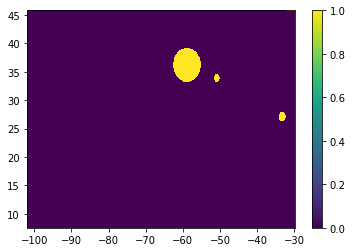

In [168]:
it_model = 0
plt.pcolormesh(lon_model_mesh, lat_model_mesh, np.squeeze(is_storm_impact[it_model,:,:]))
# plt.xlim([-78,-72])
# plt.ylim([18,22])
plt.colorbar()

In [ ]:
''' following each TC tracks and identify the t,x,y grids should be neglected that is impacted by storms '''
is_storm_impact = np.zeros( ucur_bp.shape ).astype(bool)
is_storm_impact[:] = False
print(is_storm_impact.shape, np.sum(is_storm_impact))
lon_model_mesh, lat_model_mesh = np.meshgrid( longitude, latitude )
dsec = 60 # sec
r34_sub = 50 # nmiles
''' Extend the impact for each spatial grid in time for storm impacts '''
add_model_sec_storm_impact = 12*3600
print('add seconds that is considered impact by storm afterwards',add_model_sec_storm_impact)
''' Go through each track data '''
for s, track_data in enumerate(dataTC):
    track_data = list(track_data)
    # print(s, track_data)
    it_model = np.where( np.abs(time - track_data[1])< dsec )[0]
    if len(it_model) == 1:
        print(track_data, datetime.datetime.fromtimestamp(track_data[1]))
        dist2xy = np.nan*np.ones( (len(latitude),len(longitude)) )
        for i, lon in enumerate( longitude ):
            for j, lat in enumerate( latitude ):
                dist2xy[j,i] = distance(track_data[3], track_data[2], lat, lon)
        ''' substitude undefined R34 (-9999) to a specified length '''
        r34 = 1.852*np.array(track_data[6:])
        for k in range( len(r34) ):
            if r34[k] < 0:
                r34[k] = 1.852*r34_sub
        ''' Look at each quadrant '''
        ''' 1st quadrant '''
        test1 = (lon_model_mesh>= xc) & (lat_model_mesh>= yc) & (dist2xy<= r34[0])
        ''' 2nd quadrant '''
        test2 = (lon_model_mesh<= xc) & (lat_model_mesh>= yc) & (dist2xy<= r34[1])
        ''' 3rd quadrant '''
        test3 = (lon_model_mesh<= xc) & (lat_model_mesh<= yc) & (dist2xy<= r34[2])
        ''' 4th quadrant '''
        test4 = (lon_model_mesh>= xc) & (lat_model_mesh<= yc) & (dist2xy<= r34[3])
        ''' storm impact from this track data '''
        is_storm_impact_this_track = test1 | test2 | test3 | test4
        ''' extend storm impact after specific times '''
        it_impact = np.where( (time>= time[it_model]) & (time<= time[it_model]+add_model_sec_storm_impact) )[0]
        ''' record them '''
        is_storm_impact[it_impact,:,:] = is_storm_impact[it_model,:,:] | is_storm_impact_this_track
        if np.sum(is_storm_impact_this_track) == 0:
            print('No storm impact is recorded for',track_data)
        # break

(648, 551, 901) 0
add seconds that is considered impact by storm afterwards 43200
['GERT', 1693810800.00004, -50.9, 33.9, 0.0, 45.0, 40.0, 50.0, 30.0, 0.0] 2023-09-04 00:00:00.000040
['GERT', 1693821600.00004, -50.7, 35.1, 0.0, 45.0, 40.0, 55.0, 30.0, 0.0] 2023-09-04 03:00:00.000040
['GERT', 1693832400.00004, -50.7, 36.5, 0.0, 45.0, 40.0, 60.0, 30.0, 0.0] 2023-09-04 06:00:00.000040
['GERT', 1693843200.00004, -50.7, 37.9, 0.0, 43.0, 40.0, 60.0, 15.0, 0.0] 2023-09-04 09:00:00.000040
['GERT', 1693854000.00004, -50.8, 39.4, -3.0, 40.0, 40.0, 60.0, 0.0, 0.0] 2023-09-04 12:00:00.000040
['FRANKLIN', 1693810800.00004, -30.8, 47.8, -4.0, 50.0, 130.0, 180.0, 220.0, 180.0] 2023-09-04 00:00:00.000040
['FRANKLIN', 1693821600.00004, -29.6, 47.7, -4.0, 48.0, 130.0, 180.0, 210.0, 195.0] 2023-09-04 03:00:00.000040
['FRANKLIN', 1693832400.00004, -28.6, 47.5, -4.0, 45.0, 130.0, 180.0, 200.0, 210.0] 2023-09-04 06:00:00.000040
['FRANKLIN', 1693843200.00004, -27.8, 47.3, -4.0, 43.0, 65.0, 90.0, 200.0, 225.0

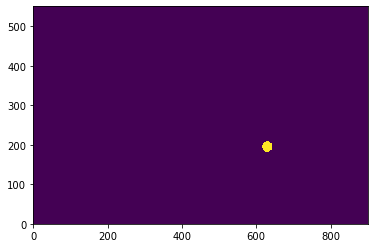

In [199]:
test = is_storm_impact[it_model,:,:] | is_storm_impact_this_track
plt.pcolormesh(is_storm_impact_this_track)
# plt.pcolormesh(lon_model_mesh, lat_model_mesh, test)
# plt.colorbar()

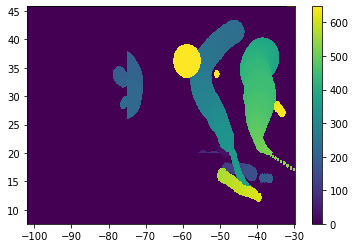

In [189]:
plt.pcolormesh(lon_model_mesh, lat_model_mesh, np.sum(is_storm_impact,axis=0))
plt.colorbar()